# ML-8. Pipelines

In [16]:
#загрузим основные библиотеки
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
 
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score


Попробуем предсказать цену на недвижимость в Калифорнии

## Часть 1. Простейшие пайплайны


Загрузим данные

In [2]:
data = fetch_california_housing()

In [3]:
df = pd.DataFrame(data['data'], columns=data['feature_names'])
df.loc[:,'target'] = data['target']
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


In [7]:
def rmse(y_hat, y):
    return mean_squared_error(y_hat, y, squared = False)

In [5]:
X = df.drop('target', axis=1)
Y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42)


In [6]:
print(f'Размер обучающей выборки {X_train.shape}')
print(f'Размер тестовой выборки {X_test.shape}')

Размер обучающей выборки (15480, 8)
Размер тестовой выборки (5160, 8)


In [7]:
pipeline = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestRegressor())])
pipeline.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()), ('rf', RandomForestRegressor())])

In [8]:
y_pred = pipeline.predict(X_test)
print(f'Качество по метрике R2: { round(r2_score(y_test, y_pred),4)}')
print(f'Качество по RSME: {round(rmse(y_test, y_pred),4)}')

Качество по метрике R2: 0.8079
Качество по RSME: 0.5042


In [9]:
pipeline.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()), ('rf', RandomForestRegressor())],
 'verbose': False,
 'scaler': StandardScaler(),
 'rf': RandomForestRegressor(),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'rf__bootstrap': True,
 'rf__ccp_alpha': 0.0,
 'rf__criterion': 'squared_error',
 'rf__max_depth': None,
 'rf__max_features': 1.0,
 'rf__max_leaf_nodes': None,
 'rf__max_samples': None,
 'rf__min_impurity_decrease': 0.0,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 2,
 'rf__min_weight_fraction_leaf': 0.0,
 'rf__n_estimators': 100,
 'rf__n_jobs': None,
 'rf__oob_score': False,
 'rf__random_state': None,
 'rf__verbose': 0,
 'rf__warm_start': False}

In [10]:
print(pipeline[1].n_estimators)
print(pipeline['rf'].n_estimators)

100
100


In [11]:
pipeline.set_params(rf__n_estimators=200)

Pipeline(steps=[('scaler', StandardScaler()),
                ('rf', RandomForestRegressor(n_estimators=200))])

In [12]:
from sklearn.model_selection import GridSearchCV
param_grid = {'scaler__with_mean':[True,False],
              'rf__n_estimators':[100, 200, 500]}
grid_search = GridSearchCV(pipeline, param_grid=param_grid, verbose = True)


In [13]:
grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Pipeline(steps=[('scaler', StandardScaler()),
                ('rf', RandomForestRegressor(n_estimators=500))])


In [14]:
y_pred = grid_search.best_estimator_.predict(X_test)
print(f'Качество по метрике R2: { round(r2_score(y_test, y_pred),4)}')
print(f'Качество по RSME: {round(rmse(y_test, y_pred),4)}')

Качество по метрике R2: 0.8092
Качество по RSME: 0.5024


# Часть 2. Предобработка в пайплайнах

In [15]:
df_wine = pd.read_csv('Red.csv')

In [16]:
df_wine.head()

,Name,Country,Region,Winery,Rating,NumberOfRatings,Price,Year
0,Pomerol 2011,France,Pomerol,Château La Providence,4.2,100,95.00,2011
1,Lirac 2017,France,Lirac,Château Mont-Redon,4.3,100,15.50,2017
2,Erta e China Rosso di Toscana 2015,Italy,Toscana,Renzo Masi,3.9,100,7.45,2015
3,Bardolino 2019,Italy,Bardolino,Cavalchina,3.5,100,8.72,2019
4,Ried Scheibner Pinot Noir 2016,Austria,Carnuntum,Markowitsch,3.9,100,29.15,2016


In [17]:
df_wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8666 entries, 0 to 8665
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             8666 non-null   object 
 1   Country          8666 non-null   object 
 2   Region           8666 non-null   object 
 3   Winery           8666 non-null   object 
 4   Rating           8666 non-null   float64
 5   NumberOfRatings  8666 non-null   int64  
 6   Price            8666 non-null   float64
 7   Year             8666 non-null   object 
dtypes: float64(2), int64(1), object(5)
memory usage: 541.8+ KB


In [18]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
ct = make_column_transformer(
     (StandardScaler(), ['Price']),
    (OneHotEncoder(), ['Country']))
print(ct)

ColumnTransformer(transformers=[('standardscaler', StandardScaler(), ['Price']),
                                ('onehotencoder', OneHotEncoder(),
                                 ['Country'])])


In [ ]:
#from sklearn.compose import make_column_selector
#import numpy as np

#ct_filtered = make_column_transformer(
#       (StandardScaler(), make_column_selector(dtype_include=np.number)),
#       (OneHotEncoder(), make_column_selector(dtype_include=object))
#)

#print(ct)

In [19]:
pipeline = Pipeline([('ct', ct), ('rf', RandomForestRegressor())])

In [20]:
X = df_wine[['Country', 'Price']]
y = df_wine['Rating']

In [21]:
pipeline.fit(X, y)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(), ['Price']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['Country'])])),
                ('rf', RandomForestRegressor())])

In [22]:
pd.DataFrame(pipeline['ct'].transform(X).toarray(), columns = ['Price']+ pipeline['ct'].transformers_[1][1].get_feature_names_out().tolist())

,Price,Country_Argentina,Country_Australia,Country_Austria,Country_Brazil,Country_Bulgaria,Country_Canada,Country_Chile,Country_China,Country_Croatia,...,Country_Portugal,Country_Romania,Country_Slovakia,Country_Slovenia,Country_South Africa,Country_Spain,Country_Switzerland,Country_Turkey,Country_United States,Country_Uruguay
0,0.657648,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.278402,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.373184,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.358231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.117684,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8661,-0.266981,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8662,-0.224358,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8663,-0.178910,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8664,-0.387784,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
#!pip install joblib
import joblib
joblib.dump(pipeline, 'pipeline.pkl')

['pipeline.pkl']

In [24]:
pipeline_loaded = joblib.load('pipeline.pkl')


In [25]:
print(pipeline_loaded)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(), ['Price']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['Country'])])),
                ('rf', RandomForestRegressor())])


In [9]:
# 6.1

df_wine = pd.read_csv('Red.csv')
df_test = pd.read_csv('Red_test.csv')

X = df_wine[['Country', 'Price', 'Region']]
y = df_wine['Rating']

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer

ct = make_column_transformer(
    (OneHotEncoder(), ['Region']),
     (StandardScaler(), ['Price']),
    (OneHotEncoder(), ['Country']))

pipeline = Pipeline([('ct', ct), ('rf', RandomForestRegressor(random_state=42))])
pipeline.fit(X, y)

X_test = df_test[['Country', 'Price', 'Region']]
y_test = df_test['Rating']

y_pred = pipeline.predict(X_test)
print(f'Качество по RSME: {round(rmse(y_test, y_pred),4)}')

Качество по RSME: 0.0772


In [12]:
joblib.dump(pipeline, 'pipeline_vine.pkl')

['pipeline_vine.pkl']

In [14]:
# 6.2 n_estimators в случайном лесу со значения по умолчанию до 200

pipeline.set_params(rf__n_estimators=200)

pipeline.fit(X, y)

df_wine_test = pd.read_csv('Red_test.csv')
X_test = df_wine_test[['Country', 'Price', 'Region']]
y_test = df_wine_test['Rating']


y_pred = pipeline.predict(X_test)
print(f'Качество по RSME: {round(rmse(y_test, y_pred),4)}')

Качество по RSME: 0.0767


In [21]:
# 6.3

from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.tree import DecisionTreeRegressor

estimators = [
    ('lr', RidgeCV()),
    ('dt',  DecisionTreeRegressor(random_state=42))
]

# Создаем объект класса стекинг
reg = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor(n_estimators=10,
                                          random_state=42)
)

pipeline = Pipeline([('ct', ct), ('sr', reg)])
pipeline.fit(X, y)

X_test = df_test[['Country', 'Price', 'Region']]
y_test = df_test['Rating']

y_pred = pipeline.predict(X_test)
print(f'Качество по RSME: {round(rmse(y_test, y_pred),4)}')

Качество по RSME: 0.1782


Метод ближайших соседей

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
from sklearn.neighbors import KNeighborsClassifier

In [25]:
data = pd.DataFrame([[0,0,0],[0.2,0.1,0], [1,0,0], [2,1,1],[2.5,0.9,1], [3,1,1]], columns = ['x','y', 'target'])
data

,x,y,target
0,0.0,0.0,0
1,0.2,0.1,0
2,1.0,0.0,0
3,2.0,1.0,1
4,2.5,0.9,1
5,3.0,1.0,1


In [26]:
X = data.drop(['target'],axis = 1)
Y = data['target']

In [27]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X, Y)

KNeighborsClassifier(n_neighbors=3)

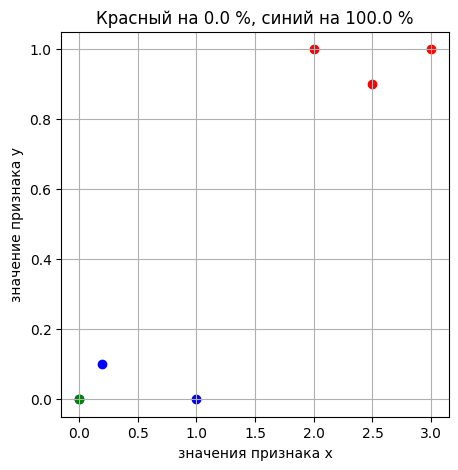

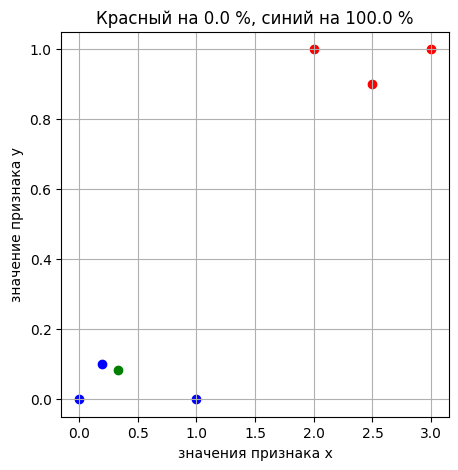

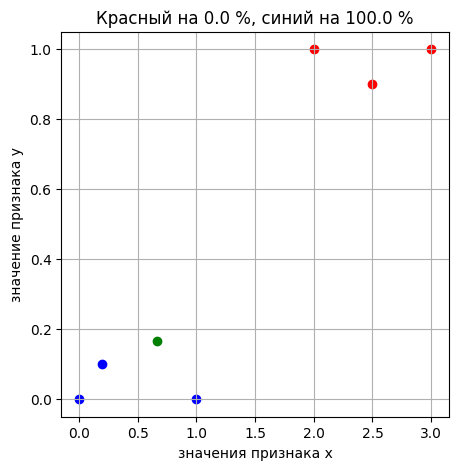

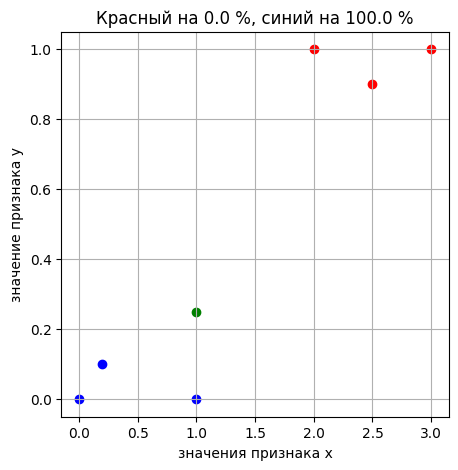

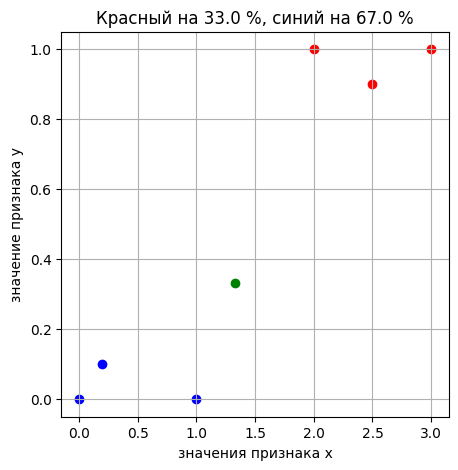

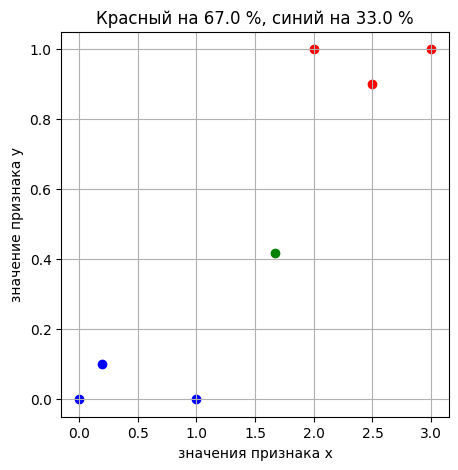

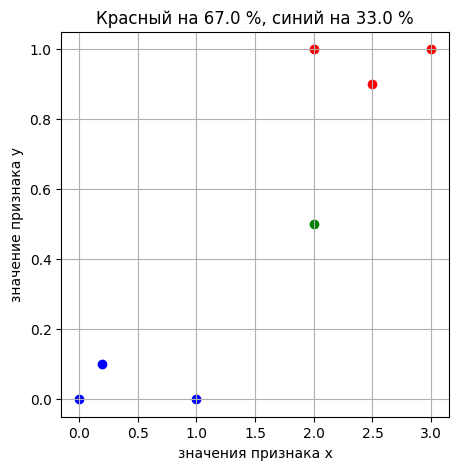

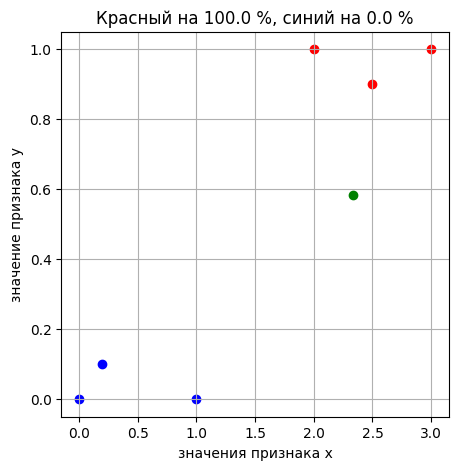

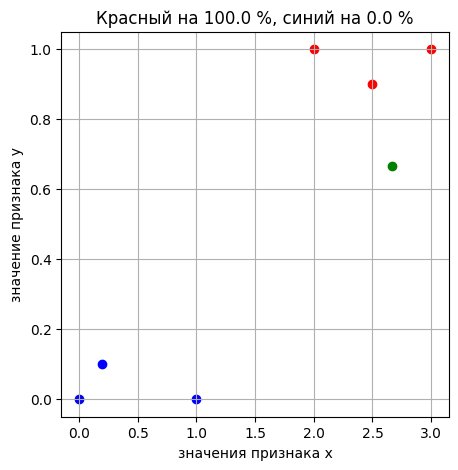

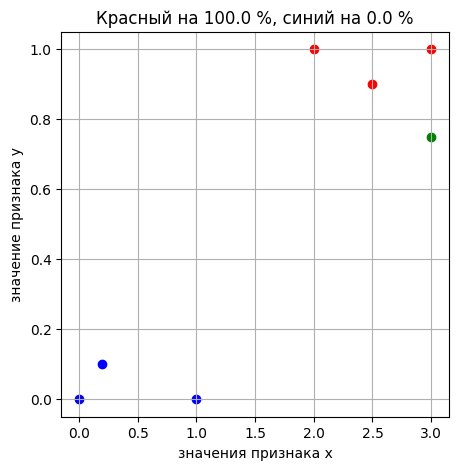

In [28]:
for item in np.linspace(0,3,10):
    x = item
    y = item*0.25
    plt.figure(figsize = (5,5))
    red = data[data.target == 1]
    blue = data[data.target == 0]
    red_prob = round(neigh.predict_proba([[x,y]])[0][1],2)*100 #вероятность принадлежности к красным
    blue_prob = round(neigh.predict_proba([[x,y]])[0][0],2)*100 #вероятность принадлежности к синим
    plt.title(f'Красный на {red_prob} %, синий на {blue_prob} %')
    plt.xlabel('значения признака x')
    plt.ylabel('значение признака y')
    plt.scatter(red.x.values,red.y.values ,c= 'r')
    plt.scatter(blue.x.values,blue.y.values ,c= 'b')
    plt.scatter(x,y ,c= 'g')
    plt.grid()
    plt.show()

БЕЗ УЧЕТА РАССТОЯНИЯ: Вероятность класса для пяти соседей в данной задаче: 4 — нулевого класса, 1 — единичного. Таким образом, среди пяти соседей вероятность нулевого класса составляет класса ⅘, то есть 0.8.

С УЧЕТОМ РАССТОЯНИЯ: Как мы убедились ранее, с учётом расстояния до соседей вероятность напрямую зависит от расстояния до объектов классов. Без информации о взаимном расположении точек в -мерном пространстве мы даже не можем сказать, какой это будет класс (единичный или нулевой).